<a href="https://colab.research.google.com/github/romanbash/DTSA-5511-disaster-Detection/blob/main/twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***DTSA-5511: Week 4 - Natural Language Processing with Disaster Tweets***

## Github: !!!!!!!!!!!!!!!!!!!!!!!!!

## Part 1: Brief Description of the Problem and Data

In this project, part of the introduction to deep learning course, we will try to make a model that can tell from a tweet whether the text is about a disaster.
The data in this project are tweets. They have three meaningful features: the full text of the tweet, the location from which the tweet was made, and a keyword the authors tagged as potentially indicating an accident. Note that not all keyword inclusions are the result of disasters, and not all the rows of the data set contain keywords and locations.

I will pull the data. We will construct a couple of LSTM and a TF-IDF with random forest algorithms to classify binary text data as either "disaster" or "not a disaster."
The data come from a (Kaggle "getting started" competition)[https://www.kaggle.com/competitions/nlp-getting-started/overview] designed to be an introduction to Natural Language Processing.
 I will utilize TensorFlow's Keras API to build a recurrent neural network to perform binary classification. A recurrent neural network is suited for data with a fixed series, for example, time series data like stock price, code translation from one language to machine language, next-frame generation from videos and/or gifs, and, as I perform in the following project, text classification in buckets—disaster vs. not disaster.

First, Let's import all the packages we would use in our project.

In [1]:
from google.colab import drive
import numpy as np # linear algebra
import matplotlib.pyplot as plt # data visualization
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
import tensorflow as tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import string
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

from collections import defaultdict
from collections import Counter

import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import (LSTM,
                          Embedding,
                          BatchNormalization,
                          Dense,
                          TimeDistributed,
                          Dropout,
                          Bidirectional,
                          Flatten,
                          GlobalMaxPool1D)
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    accuracy_score
)


drive.mount('/content/drive')



Mounted at /content/drive


Let's check if the GPU works.

In [2]:
# Check for GPU availability
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

# Specify the GPU device to use
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Enable GPU acceleration
tf.keras.backend.set_image_data_format('channels_last')
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

GPU is not available


This hack if for quicker IO of data. We unzip all the data to "/content".

In [3]:
!unzip -q "/content/drive/MyDrive/DTSA 5511/Week 4/nlp-getting-started.zip" -d "/content"

In [4]:
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

# Exploratory Data Analysis

In [5]:
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


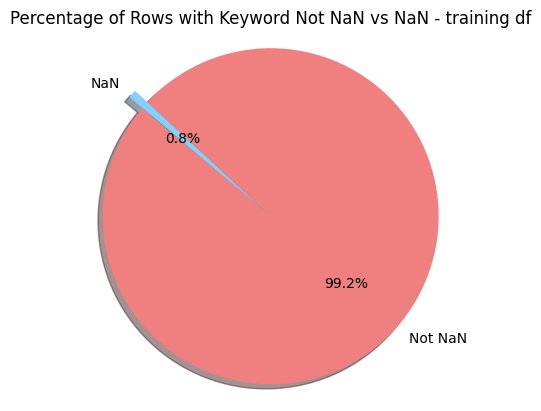

In [6]:
# plot  the precentage of rows wehre keyword is not Nan compared to NaN


not_nan_count = train_df['keyword'].notna().sum()
nan_count = train_df['keyword'].isna().sum()

# Calculate percentages
not_nan_percentage = (not_nan_count / len(train_df)) * 100
nan_percentage = (nan_count / len(train_df)) * 100

# Create the pie chart
labels = ['Not NaN', 'NaN']
sizes = [not_nan_percentage, nan_percentage]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)  # Explode the 'Not NaN' slice

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Percentage of Rows with Keyword Not NaN vs NaN - training df')
plt.show()

So we have the ketword for most of the data

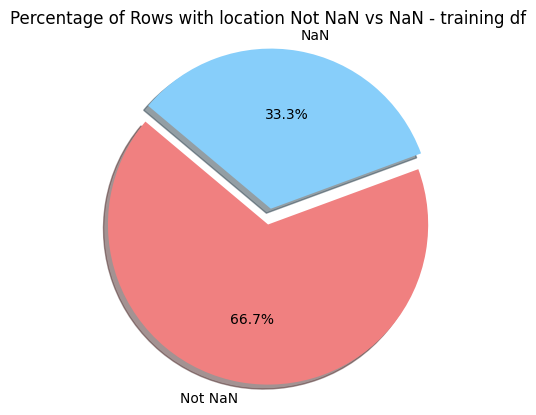

In [7]:
# Assuming 'keyword' is the column you want to analyze
not_nan_count = train_df['location'].notna().sum()
nan_count = train_df['location'].isna().sum()

# Calculate percentages
not_nan_percentage = (not_nan_count / len(train_df)) * 100
nan_percentage = (nan_count / len(train_df)) * 100

# Create the pie chart
labels = ['Not NaN', 'NaN']
sizes = [not_nan_percentage, nan_percentage]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)  # Explode the 'Not NaN' slice

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Percentage of Rows with location Not NaN vs NaN - training df')
plt.show()

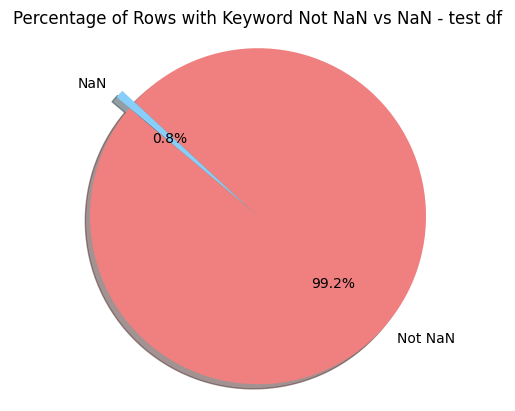

In [8]:
not_nan_count = test_df['keyword'].notna().sum()
nan_count = test_df['keyword'].isna().sum()

# Calculate percentages
not_nan_percentage = (not_nan_count / len(train_df)) * 100
nan_percentage = (nan_count / len(train_df)) * 100

# Create the pie chart
labels = ['Not NaN', 'NaN']
sizes = [not_nan_percentage, nan_percentage]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)  # Explode the 'Not NaN' slice

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Percentage of Rows with Keyword Not NaN vs NaN - test df')
plt.show()

The same precentage is on the test set.

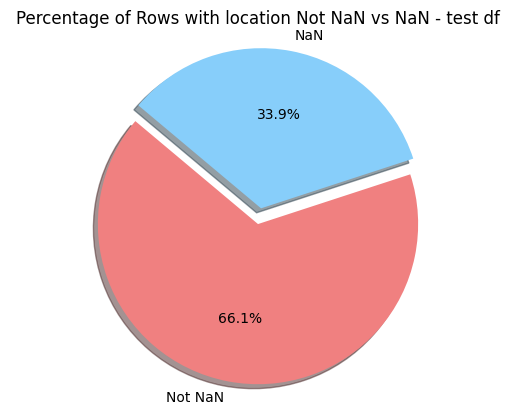

In [9]:
not_nan_count = test_df['location'].notna().sum()
nan_count = test_df['location'].isna().sum()

# Calculate percentages
not_nan_percentage = (not_nan_count / len(train_df)) * 100
nan_percentage = (nan_count / len(train_df)) * 100

# Create the pie chart
labels = ['Not NaN', 'NaN']
sizes = [not_nan_percentage, nan_percentage]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)  # Explode the 'Not NaN' slice

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Percentage of Rows with location Not NaN vs NaN - test df')
plt.show()

The location is trickier. It's a good quation if we should or should not use it.

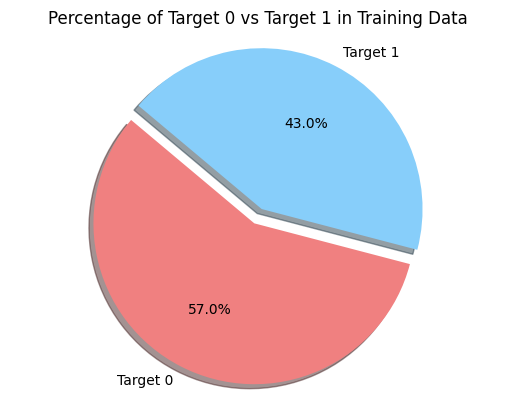

In [10]:
# prompt: in training df plot the number of target 1 compared to target 0 with precentages in pie cahrt

# Count the number of target 1 and target 0
target_counts = train_df['target'].value_counts()

# Calculate percentages
target_percentages = target_counts / len(train_df) * 100

# Create the pie chart
labels = ['Target 0', 'Target 1']
sizes = [target_percentages[0], target_percentages[1]]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)  # Explode the 'Target 0' slice

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Percentage of Target 0 vs Target 1 in Training Data')
plt.show()

The data is not balanced, but it is close to being balanced. We would try to handle it as if it were balanced.

# Data preprocessing #

First, we Make text lowercase, remove text in square brackets, remove links, remove punctuation, and remove words containing numbers.

In [11]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [12]:
train_df['text_clean'] = train_df['text'].apply(clean_text)
train_df.head()

,id,keyword,location,text,target,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders in...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...


Then we remove all the stopwords.

In [13]:
import nltk
nltk.download('stopwords')

stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

train_df['text_clean'] = train_df['text_clean'].apply(remove_stopwords)
train_df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,id,keyword,location,text,target,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders ca...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...


Then, we apply stemming to each text entry using the Snowball stemmer and update the column with the stemmed text to reduce the dimensionality of text data and improve the accuracy of models.

In [14]:
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

train_df['text_clean'] = train_df['text_clean'].apply(stemm_text)
train_df.head()

,id,keyword,location,text,target,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquak may allah forgiv us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la rong sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resid ask shelter place notifi offic evacu she...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,peopl receiv wildfir evacu order california
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo rubi alaska smoke wildfir pour ...


Let's plot the most common word in the disaster, labeled tweets.

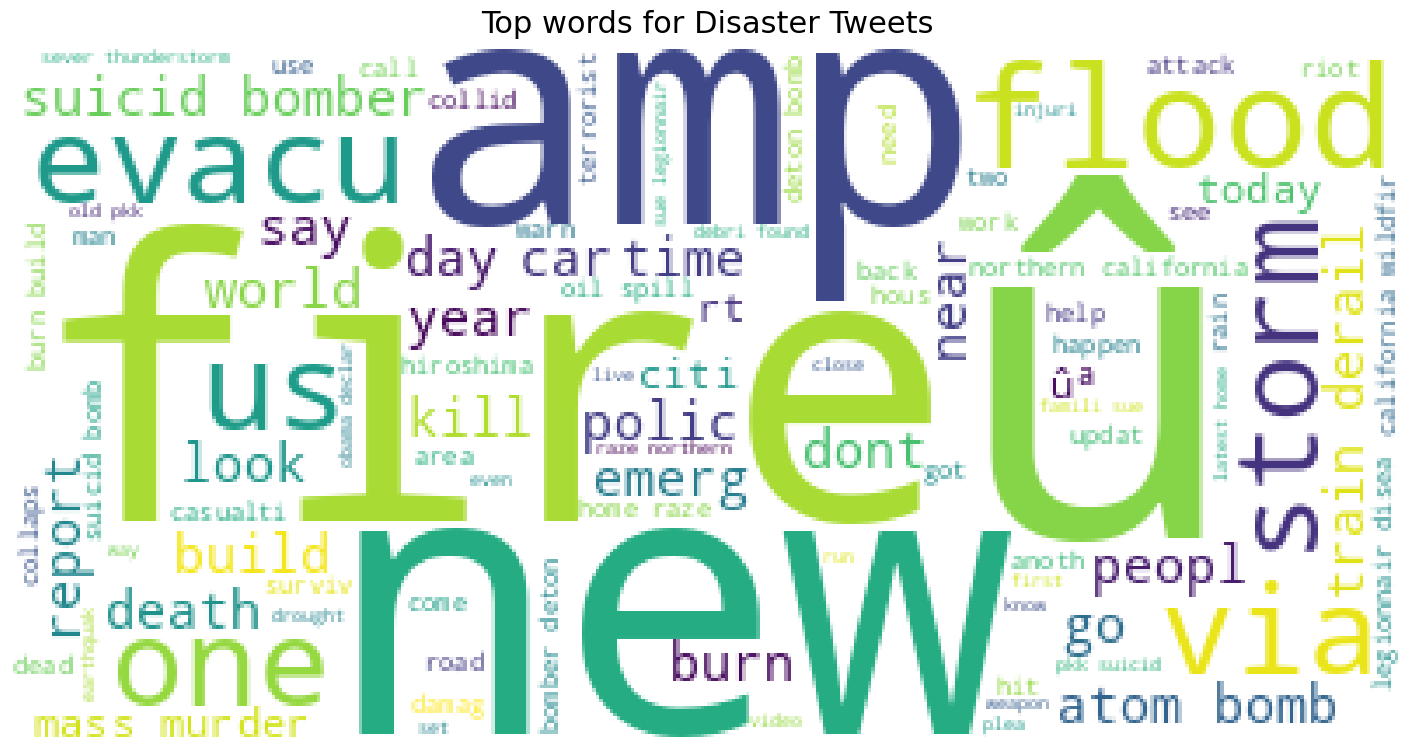

In [15]:
wc = WordCloud(
    background_color='white',
    max_words=200
)
wc.generate(' '.join(text for text in train_df.loc[train_df['target'] == 1, 'text_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for Disaster Tweets',
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

Let's try to understand wht the word 'amp" is so common.

In [16]:
rows_with_amp_and_target_1 = train_df[(train_df['target'] == 1) & (train_df['text'].str.contains('amp', na=False))]

# Create a formatted display
print(rows_with_amp_and_target_1[['text', 'target']].to_string(index=False))

                                                                                                                                                   text  target
                      Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FVCK #flooding       1
                                                                           #raining #flooding #Florida #TampaBay #Tampa 18 or 19 days. I've lost count        1
                #Kurds trampling on Turkmen flag later set it ablaze while others vandalized offices of Turkmen Front in #Diyala http://t.co/4IzFdYC3cg       1
                                                             I-77 Mile Marker 31 South Mooresville  Iredell Vehicle Accident Ramp Closed at 8/6 1:18 PM       1
                A Cessna airplane accident in Ocampo Coahuila Mexico on July 29 2015 killed four men including a State of Coahuila government official.       1
                                   Early

&amp is not a word; it is an HTML symbol, so we should remove it from our clean text.

In [17]:
train_df['text_clean'] = train_df['text_clean'].str.replace('&amp', '')

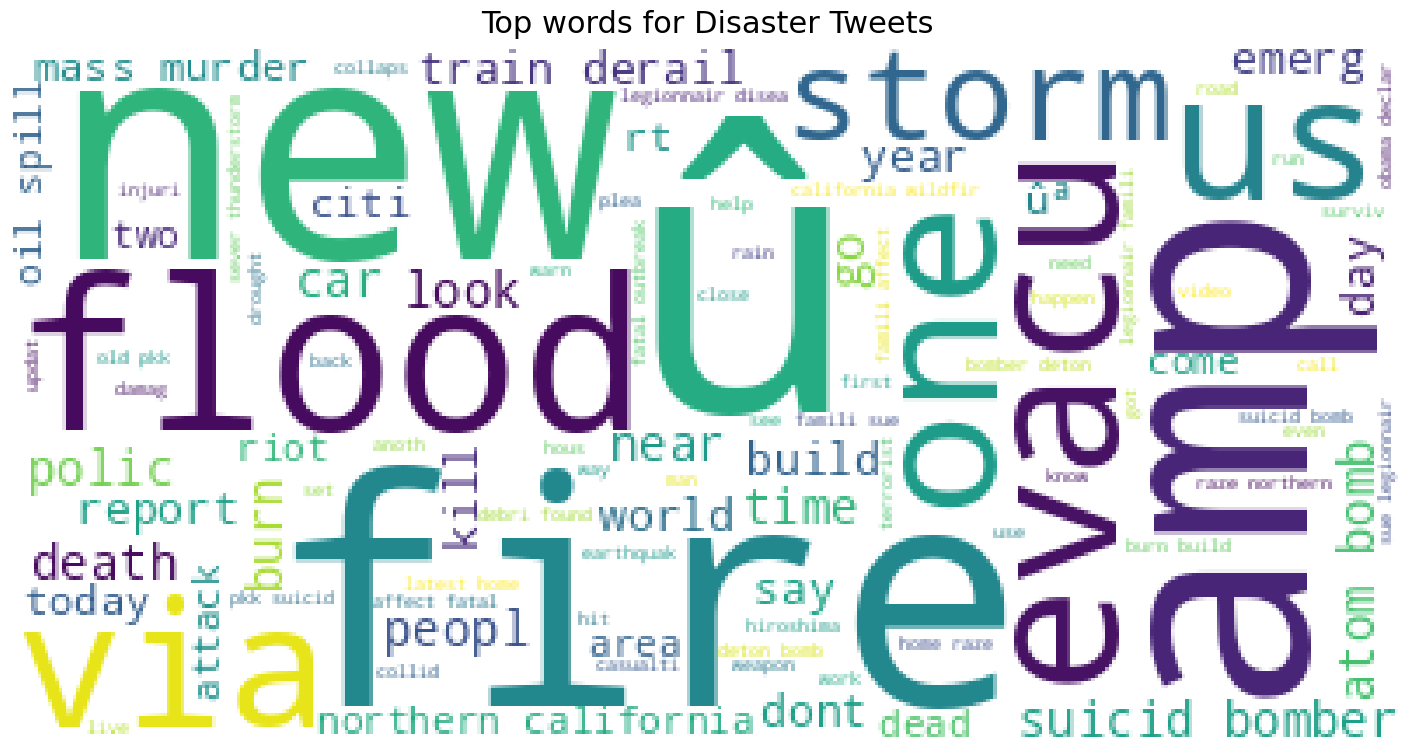

In [18]:
wc = WordCloud(
    background_color='white',
    max_words=200
)
wc.generate(' '.join(text for text in train_df.loc[train_df['target'] == 1, 'text_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for Disaster Tweets',
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

# The models #

In this section, we will try three different models: A TF-IDF + random forest and two different LSTM archtectures.

**TF-IDF** (Term Frequency-Inverse Document Frequency):


*   A numerical statistic that reflects how important a word is to a document in a collection or corpus.
*   alculates a weight for each word based on its frequency in the document and its inverse frequency across all documents.
*   Higher TF-IDF scores indicate words that are more important or distinctive to a particular document.

**Random Forest**:



*   An ensemble learning method that combines multiple decision trees to make predictions.
*   Each decision tree is trained on a random subset of the data and features.
*   The final prediction is made by aggregating the predictions of all the individual trees.

## **How they work together?**

TF-IDF is used to convert text data into numerical features that can be used by the Random Forest model.
The Random Forest model learns to classify text based on the TF-IDF features.




Let's split our data to training and validation.

In [19]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df['text_clean'], train_df['target'], test_size=0.2, random_state=42)

We use TF-IDF to convert text data into numerical features for use in a machine learning model. It learns the vocabulary and IDF weights from the training data and then uses those to transform both the training and validation data into TF-IDF feature matrices. This process ensures that the features are consistent and comparable across the two datasets.

In [20]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_valid = vectorizer.transform(X_valid)

Now let's train our random forest on the TF-IDF output.

In [21]:
# Create a Random Forest Regressor
rf_classifier = RandomForestClassifier(n_estimators=500, random_state=42)

In [22]:
# Train the regressor
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, random_state=42)

and save our model for future use.

In [23]:
import pickle

# Assuming rf_regressor is your trained model
with open('/content/drive/MyDrive/DTSA 5511/Week 4/rf_classifier.pkl', 'wb') as f:
  pickle.dump(rf_classifier, f)

Let's test our model on our validation set.

In [24]:
# Make predictions on the test set
y_pred = rf_classifier.predict(X_valid)

In [25]:
# Evaluate the model using classification metrics
accuracy = accuracy_score(y_valid, y_pred)
classification_rep = classification_report(y_valid, y_pred)

# Print the results
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{classification_rep}")

Accuracy: 0.7879185817465528
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       874
           1       0.78      0.70      0.74       649

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523



The results are not bad! We received almost 80% accuracy.



Let's upload to Kaggle to see whether our results are promising.

In [26]:
test_df['text_clean'] = test_df['text'].apply(clean_text)
test_df['text_clean'] = test_df['text_clean'].apply(remove_stopwords)
test_df['text_clean'] = test_df['text_clean'].apply(stemm_text)

In [27]:
series_from_text_clean = pd.Series(test_df['text_clean'])
print(series_from_text_clean)

0                                happen terribl car crash
1           heard earthquak differ citi stay safe everyon
2       forest fire spot pond gees flee across street ...
3                          apocalyps light spokan wildfir
4                     typhoon soudelor kill  china taiwan
                              ...                        
3258    earthquak safeti los angel ûò safeti fasten xrwn
3259    storm ri wors last hurrican  hardest hit yard ...
3260                           green line derail chicago 
3261                 meg issu hazard weather outlook hwo 
3262      cityofcalgari activ municip emerg plan yycstorm
Name: text_clean, Length: 3263, dtype: object


In [28]:
X_test = vectorizer.transform(series_from_text_clean)

In [29]:
y_pred = rf_classifier.predict(X_test)

In [30]:
y_submit = []
for val in y_pred:
    if val >= 0.5:
        y_submit += [1]
    else:
        y_submit += [0]

In [31]:
test_id = pd.DataFrame(test_df["id"])
merged_df = pd.concat([test_id, pd.DataFrame(y_submit, columns=["target"])], axis=1)

In [32]:
merged_df.to_csv('/content/drive/MyDrive/DTSA 5511/Week 4/output.csv', index = False)

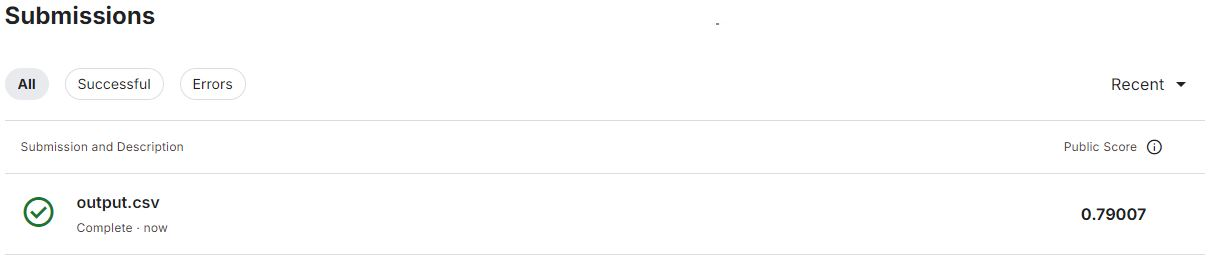

Not bad at all for a simple model as random forest!



---



## LSTM model

LSTM (Long Short-Term Memory)

* A type of recurrent neural network (RNN) designed to capture long-term dependencies in sequential data like text.

* Has memory cells that can store information over time, allowing it to learn patterns in sequences.
* Can process text data word-by-word, taking into account the context of previous words.

**Architecture**:

* consists of an embedding layer to represent words as vectors, one or more LSTM layers to process the sequence, and a dense output layer for classification.
* The LSTM layers learn to represent the meaning of the text by capturing the relationships between words in the sequence.

In [33]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df['text_clean'], train_df['target'], test_size=0.2, random_state=42)


Let's build a tokenizaion first. We will keep only the top 3000 most frequent words in the vocabulary.

Tokenization: Breaks down your text into individual words (tokens).
Vocabulary building: Creates a dictionary that maps each word to a unique numerical index.
Sequence generation: Converts your text data into numerical sequences based on the vocabulary.
Padding: Ensures all sequences have the same length by adding padding.

In [34]:
tokenizer = Tokenizer(num_words = 3000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding = "post")

test_sequences = tokenizer.texts_to_sequences(X_valid)
test_padded = pad_sequences(test_sequences, padding = "post", maxlen= train_padded.shape[1])

Now we build our model.

In [35]:
from keras.metrics import F1Score
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(3000, 33),#, input_length=test_padded[1]
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(33, return_sequences = True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(33, return_sequences = True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(33)),
    #tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=[F1Score(threshold = 0.5)])#'accuracy'

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [36]:
history = model.fit(
    train_padded,
    y_train,
    epochs = 20,
    batch_size = 32,
    validation_data = (test_padded, y_valid),
    verbose = 1
)

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 32s 93ms/step - f1_score: 0.3608 - loss: 0.6231 - val_f1_score: 0.7500 - val_loss: 0.4560
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - f1_score: 0.8124 - loss: 0.3569 - val_f1_score: 0.7277 - val_loss: 0.4499
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 20s 85ms/step - f1_score: 0.8587 - loss: 0.3049 - val_f1_score: 0.7392 - val_loss: 0.5490
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - f1_score: 0.8829 - loss: 0.2536 - val_f1_score: 0.7258 - val_loss: 0.5290
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - f1_score: 0.8934 - loss: 0.2222 - val_f1_score: 0.7146 - val_loss: 0.5897
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 21s 81ms/step - f1_score: 0.9224 - loss: 0.1812 - val_f1_score: 0.7189 - val_loss: 0.6298
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 24s 98ms/step - f1_score: 0.9279 - loss: 0.1557 - val_f1_score: 0.7123 - val_loss: 0.8227
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - f1_score: 0.9418 - loss: 0.1278 - 

In [37]:
def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

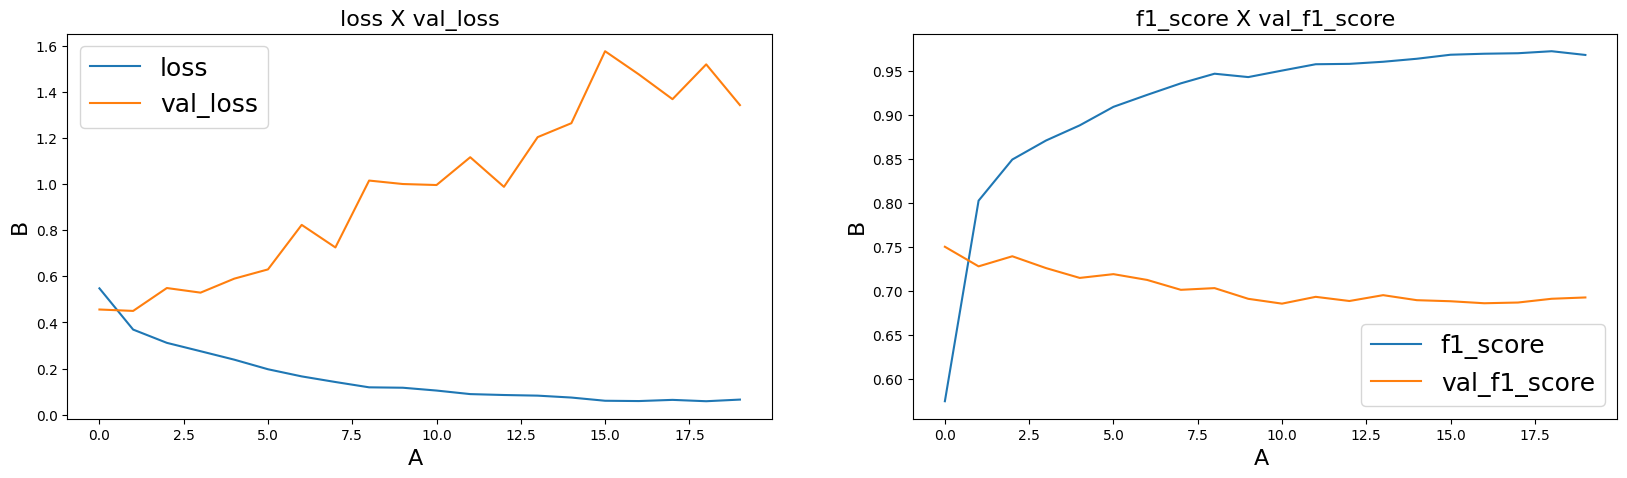

In [38]:
plot_learning_curves(history, [['loss', 'val_loss'],['f1_score', 'val_f1_score']])

In [39]:
y_pred = model.predict(test_padded)

y_pred_binary = []

for val in y_pred:
    if val >= 0.5:
        y_pred_binary += [1]
    else:
        y_pred_binary += [0]

48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step


In [40]:
# Evaluate the model using classification metrics
accuracy = accuracy_score(y_valid, y_pred_binary)
classification_rep = classification_report(y_valid, y_pred_binary)

# Print the results
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{classification_rep}")

Accuracy: 0.7334208798424163
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.76      0.76       874
           1       0.68      0.70      0.69       649

    accuracy                           0.73      1523
   macro avg       0.73      0.73      0.73      1523
weighted avg       0.73      0.73      0.73      1523



upload to kaggle

In [41]:
test_df

,id,keyword,location,text,text_clean
0,0,NaN,NaN,Just happened a terrible car crash,happen terribl car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard earthquak differ citi stay safe everyon
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond gees flee across street ...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalyps light spokan wildfir
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan
...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,earthquak safeti los angel ûò safeti fasten xrwn
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,storm ri wors last hurrican hardest hit yard ...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,green line derail chicago
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,meg issu hazard weather outlook hwo


In [42]:
test_sequences = tokenizer.texts_to_sequences(test_df['text_clean'])
test_padded = pad_sequences(test_sequences, padding = "post", maxlen= train_padded.shape[1])

In [43]:
y_pred = model.predict(test_padded)

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


In [44]:
len(y_pred)

3263

In [45]:
y_submit = []
for val in y_pred:
    if val >= 0.5:
        y_submit += [1]
    else:
        y_submit += [0]

In [46]:
test_id = pd.DataFrame(test_df["id"])
merged_df = pd.concat([test_id, pd.DataFrame(y_submit, columns=["target"])], axis=1)

In [47]:
merged_df.to_csv('/content/drive/MyDrive/DTSA 5511/Week 4/lstm_output.csv', index = False)

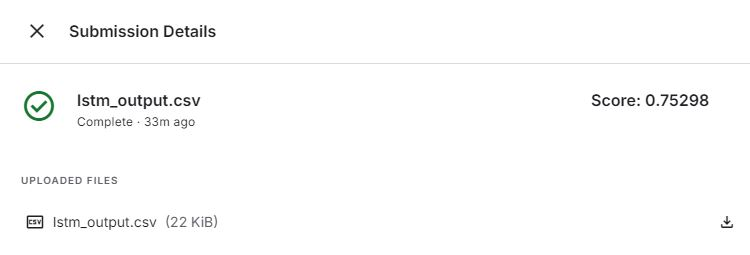



---



Impruved LSTM

In [48]:
from keras.models import Sequential

In [49]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df['text_clean'], train_df['target'], test_size=0.2, random_state=42)

In [50]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = 10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding = "post")

test_sequences = tokenizer.texts_to_sequences(X_valid)
test_padded = pad_sequences(test_sequences, padding = "post", maxlen= train_padded.shape[1])

In [51]:
model = Sequential()

model.add(Embedding(10000, 33))

model.add(Bidirectional(LSTM(
        33,
        return_sequences = True,
        recurrent_dropout=0.2
    )))

model.add(GlobalMaxPool1D())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(33, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(33, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [52]:
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    verbose = 1,
    patience = 5,
    min_lr = 0.001
)
history = model.fit(
    train_padded,
    y_train,
    epochs = 20,
    batch_size = 32,
    validation_data = (test_padded, y_valid),
    verbose = 1,
    callbacks = [reduce_lr]
)

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.5734 - loss: 0.6817 - val_accuracy: 0.6586 - val_loss: 0.6728 - learning_rate: 0.0010
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7233 - loss: 0.5566 - val_accuracy: 0.7984 - val_loss: 0.5866 - learning_rate: 0.0010
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.8198 - loss: 0.4280 - val_accuracy: 0.8004 - val_loss: 0.4666 - learning_rate: 0.0010
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.8574 - loss: 0.3755 - val_accuracy: 0.7919 - val_loss: 0.4605 - learning_rate: 0.0010
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.8799 - loss: 0.3364 - val_accuracy: 0.7886 - val_loss: 0.4915 - learning_rate: 0.0010
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.8900 - loss: 0.3141 - val_accuracy: 0.7787 - val_loss: 0.5706 - learning_rate: 0.0010
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.8985 - loss

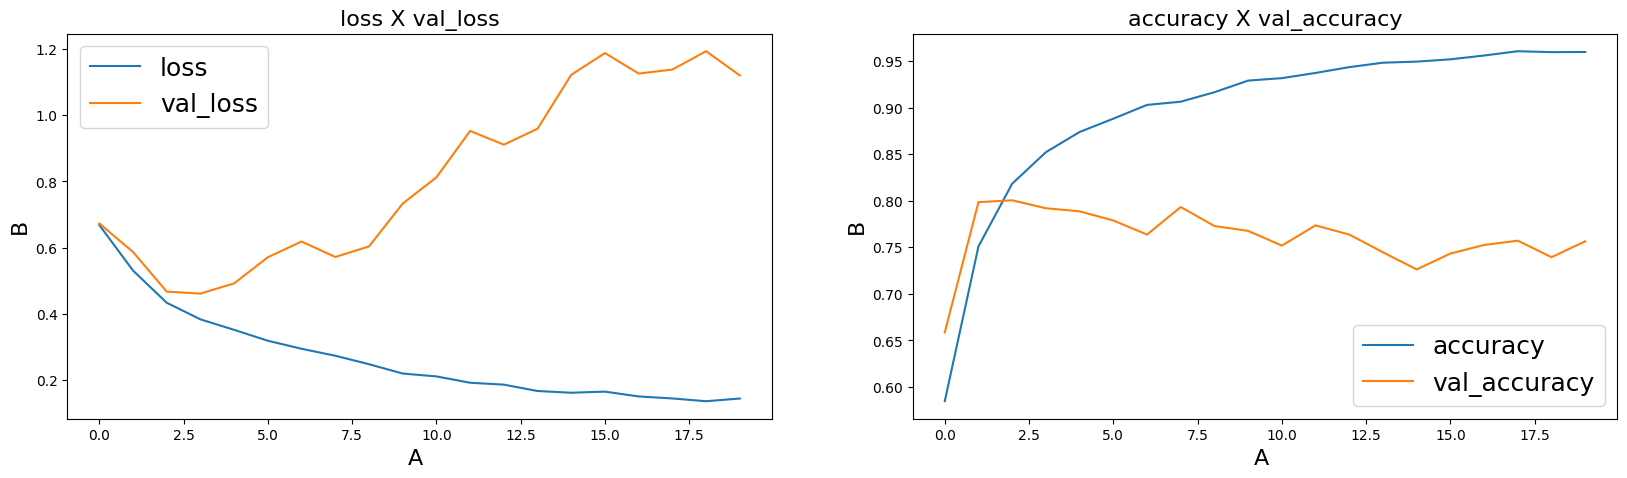

In [53]:
plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

In [54]:
y_pred = model.predict(test_padded)

y_pred_binary = []

for val in y_pred:
    if val >= 0.5:
        y_pred_binary += [1]
    else:
        y_pred_binary += [0]

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


In [55]:
# Evaluate the model using classification metrics
accuracy = accuracy_score(y_valid, y_pred_binary)
classification_rep = classification_report(y_valid, y_pred_binary)

# Print the results
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{classification_rep}")

Accuracy: 0.7564018384766907
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.81      0.79       874
           1       0.73      0.68      0.70       649

    accuracy                           0.76      1523
   macro avg       0.75      0.75      0.75      1523
weighted avg       0.76      0.76      0.76      1523



Upload to kaggle

In [56]:
test_sequences = tokenizer.texts_to_sequences(test_df['text_clean'])
test_padded = pad_sequences(test_sequences, padding = "post", maxlen= train_padded.shape[1])

y_pred = model.predict(test_padded)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [57]:
y_submit = []
for val in y_pred:
    if val >= 0.5:
        y_submit += [1]
    else:
        y_submit += [0]

In [58]:
test_id = pd.DataFrame(test_df["id"])
merged_df = pd.concat([test_id, pd.DataFrame(y_submit, columns=["target"])], axis=1)

In [59]:
merged_df.to_csv('/content/drive/MyDrive/DTSA 5511/Week 4/lstm_output2.csv', index = False)

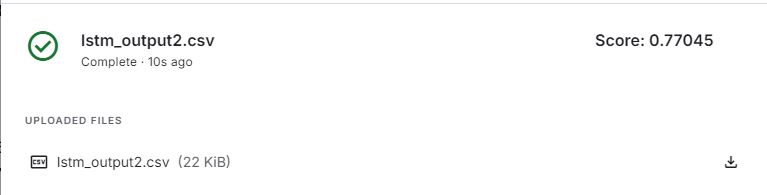